In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


   1/7342 [..............................] - ETA: 1:58:12 - loss: 0.0248 - STD: 8.7154e-05 - MAE: 0.1396

  34/7342 [..............................] - ETA: 11s - loss: 0.0116 - STD: 2.2420e-04 - MAE: 0.0840    

  70/7342 [..............................] - ETA: 10s - loss: 0.0104 - STD: 5.7000e-04 - MAE: 0.0795

 106/7342 [..............................] - ETA: 10s - loss: 0.0098 - STD: 0.0029 - MAE: 0.0774    

 139/7342 [..............................] - ETA: 10s - loss: 0.0094 - STD: 0.0105 - MAE: 0.0753

 175/7342 [..............................] - ETA: 10s - loss: 0.0088 - STD: 0.0175 - MAE: 0.0727

 213/7342 [..............................] - ETA: 10s - loss: 0.0084 - STD: 0.0232 - MAE: 0.0707

 249/7342 [>.............................] - ETA: 10s - loss: 0.0080 - STD: 0.0277 - MAE: 0.0691

 284/7342 [>.............................] - ETA: 10s - loss: 0.0078 - STD: 0.0310 - MAE: 0.0680

 322/7342 [>.............................] - ETA: 9s - loss: 0.0075 - STD: 0.0344 - MAE: 0.0667 

 361/7342 [>.............................] - ETA: 9s - loss: 0.0073 - STD: 0.0372 - MAE: 0.0657

 400/7342 [>.............................] - ETA: 9s - loss: 0.0071 - STD: 0.0395 - MAE: 0.0647

 438/7342 [>.............................] - ETA: 9s - loss: 0.0069 - STD: 0.0412 - MAE: 0.0638

 458/7342 [>.............................] - ETA: 15s - loss: 0.0069 - STD: 0.0419 - MAE: 0.0635

 487/7342 [>.............................] - ETA: 15s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0630

 522/7342 [=>............................] - ETA: 15s - loss: 0.0067 - STD: 0.0443 - MAE: 0.0625

 558/7342 [=>............................] - ETA: 14s - loss: 0.0065 - STD: 0.0455 - MAE: 0.0618

 594/7342 [=>............................] - ETA: 14s - loss: 0.0065 - STD: 0.0465 - MAE: 0.0613

 627/7342 [=>............................] - ETA: 14s - loss: 0.0064 - STD: 0.0475 - MAE: 0.0609

 660/7342 [=>............................] - ETA: 13s - loss: 0.0063 - STD: 0.0482 - MAE: 0.0607

 700/7342 [=>............................] - ETA: 13s - loss: 0.0062 - STD: 0.0492 - MAE: 0.0603

 738/7342 [==>...........................] - ETA: 13s - loss: 0.0062 - STD: 0.0501 - MAE: 0.0599

 776/7342 [==>...........................] - ETA: 12s - loss: 0.0061 - STD: 0.0507 - MAE: 0.0596

 814/7342 [==>...........................] - ETA: 12s - loss: 0.0061 - STD: 0.0512 - MAE: 0.0594

 854/7342 [==>...........................] - ETA: 12s - loss: 0.0060 - STD: 0.0516 - MAE: 0.0592

 895/7342 [==>...........................] - ETA: 11s - loss: 0.0060 - STD: 0.0521 - MAE: 0.0589

 935/7342 [==>...........................] - ETA: 11s - loss: 0.0059 - STD: 0.0526 - MAE: 0.0586

 972/7342 [==>...........................] - ETA: 11s - loss: 0.0059 - STD: 0.0530 - MAE: 0.0585

1010/7342 [===>..........................] - ETA: 11s - loss: 0.0059 - STD: 0.0533 - MAE: 0.0583

1042/7342 [===>..........................] - ETA: 11s - loss: 0.0058 - STD: 0.0536 - MAE: 0.0581

1084/7342 [===>..........................] - ETA: 11s - loss: 0.0058 - STD: 0.0540 - MAE: 0.0579

1120/7342 [===>..........................] - ETA: 10s - loss: 0.0058 - STD: 0.0542 - MAE: 0.0577

1148/7342 [===>..........................] - ETA: 10s - loss: 0.0057 - STD: 0.0545 - MAE: 0.0576

1187/7342 [===>..........................] - ETA: 10s - loss: 0.0057 - STD: 0.0546 - MAE: 0.0575

1228/7342 [====>.........................] - ETA: 10s - loss: 0.0057 - STD: 0.0549 - MAE: 0.0573

1269/7342 [====>.........................] - ETA: 10s - loss: 0.0057 - STD: 0.0552 - MAE: 0.0572

1310/7342 [====>.........................] - ETA: 10s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0571

1339/7342 [====>.........................] - ETA: 10s - loss: 0.0056 - STD: 0.0556 - MAE: 0.0570

1373/7342 [====>.........................] - ETA: 10s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0568

1413/7342 [====>.........................] - ETA: 9s - loss: 0.0055 - STD: 0.0562 - MAE: 0.0566 

1449/7342 [====>.........................] - ETA: 9s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0566

1487/7342 [=====>........................] - ETA: 9s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0564

1518/7342 [=====>........................] - ETA: 9s - loss: 0.0055 - STD: 0.0569 - MAE: 0.0564

1557/7342 [=====>........................] - ETA: 9s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0562

1597/7342 [=====>........................] - ETA: 9s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0561

1630/7342 [=====>........................] - ETA: 9s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0560

1660/7342 [=====>........................] - ETA: 9s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0559

1699/7342 [=====>........................] - ETA: 9s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0558

1734/7342 [======>.......................] - ETA: 9s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0557

1766/7342 [======>.......................] - ETA: 9s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0556

1801/7342 [======>.......................] - ETA: 9s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0555

1837/7342 [======>.......................] - ETA: 8s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0554

1868/7342 [======>.......................] - ETA: 8s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0553

1906/7342 [======>.......................] - ETA: 8s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0553

1936/7342 [======>.......................] - ETA: 8s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0552

1963/7342 [=======>......................] - ETA: 8s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0551

1989/7342 [=======>......................] - ETA: 8s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0550

2022/7342 [=======>......................] - ETA: 8s - loss: 0.0053 - STD: 0.0594 - MAE: 0.0550

2058/7342 [=======>......................] - ETA: 8s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0549

2093/7342 [=======>......................] - ETA: 8s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0548

2119/7342 [=======>......................] - ETA: 8s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0547

2150/7342 [=======>......................] - ETA: 8s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0546

2188/7342 [=======>......................] - ETA: 8s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0545

2216/7342 [========>.....................] - ETA: 8s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0545

2241/7342 [========>.....................] - ETA: 8s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0544

2270/7342 [========>.....................] - ETA: 8s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0544

2305/7342 [========>.....................] - ETA: 8s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0543

2343/7342 [========>.....................] - ETA: 8s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0542

2376/7342 [========>.....................] - ETA: 8s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0541

2414/7342 [========>.....................] - ETA: 7s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0540

2452/7342 [=========>....................] - ETA: 7s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0539

2488/7342 [=========>....................] - ETA: 7s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0539

2526/7342 [=========>....................] - ETA: 7s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0538

2563/7342 [=========>....................] - ETA: 7s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0537

2594/7342 [=========>....................] - ETA: 7s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0537

2622/7342 [=========>....................] - ETA: 7s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0536

2646/7342 [=========>....................] - ETA: 7s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0536

2674/7342 [=========>....................] - ETA: 7s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0535

2706/7342 [==========>...................] - ETA: 7s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0535

2740/7342 [==========>...................] - ETA: 7s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0534

2773/7342 [==========>...................] - ETA: 7s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0533

2812/7342 [==========>...................] - ETA: 7s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0532

2850/7342 [==========>...................] - ETA: 7s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0532

2888/7342 [==========>...................] - ETA: 7s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0531

2916/7342 [==========>...................] - ETA: 7s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0531

2953/7342 [===========>..................] - ETA: 7s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0530

2982/7342 [===========>..................] - ETA: 6s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0530

3022/7342 [===========>..................] - ETA: 6s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0529

3056/7342 [===========>..................] - ETA: 6s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0528

3081/7342 [===========>..................] - ETA: 6s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0528

3104/7342 [===========>..................] - ETA: 6s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0528

3131/7342 [===========>..................] - ETA: 6s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0527

3158/7342 [===========>..................] - ETA: 6s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0527

3184/7342 [============>.................] - ETA: 6s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0526

3211/7342 [============>.................] - ETA: 6s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0526

3242/7342 [============>.................] - ETA: 6s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0526

3279/7342 [============>.................] - ETA: 6s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0525

3317/7342 [============>.................] - ETA: 6s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0525

3352/7342 [============>.................] - ETA: 6s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0524

3382/7342 [============>.................] - ETA: 6s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0524

3417/7342 [============>.................] - ETA: 6s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0523

3450/7342 [=============>................] - ETA: 6s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0522

3482/7342 [=============>................] - ETA: 6s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0522

3519/7342 [=============>................] - ETA: 6s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0521

3547/7342 [=============>................] - ETA: 6s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0521

3575/7342 [=============>................] - ETA: 6s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0520

3601/7342 [=============>................] - ETA: 6s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0520

3635/7342 [=============>................] - ETA: 5s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0519

3664/7342 [=============>................] - ETA: 5s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0519

3691/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0519

3726/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0518

3754/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0517

3781/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0517

3805/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0517

3831/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0516

3860/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0515

3888/7342 [==============>...............] - ETA: 5s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0515

3916/7342 [===============>..............] - ETA: 5s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0514

3946/7342 [===============>..............] - ETA: 5s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0514

3974/7342 [===============>..............] - ETA: 5s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0514

3999/7342 [===============>..............] - ETA: 5s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0513

4025/7342 [===============>..............] - ETA: 5s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0513

4052/7342 [===============>..............] - ETA: 5s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0513

4074/7342 [===============>..............] - ETA: 5s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0512

4100/7342 [===============>..............] - ETA: 5s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0512

4127/7342 [===============>..............] - ETA: 5s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0512

4151/7342 [===============>..............] - ETA: 5s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0511

4178/7342 [================>.............] - ETA: 5s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0511

4203/7342 [================>.............] - ETA: 5s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0511

4228/7342 [================>.............] - ETA: 5s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

4255/7342 [================>.............] - ETA: 5s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

4285/7342 [================>.............] - ETA: 5s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0509

4308/7342 [================>.............] - ETA: 5s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0509

4341/7342 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0509

4369/7342 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0508

4393/7342 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0508

4420/7342 [=================>............] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0508

4446/7342 [=================>............] - ETA: 4s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0507

4472/7342 [=================>............] - ETA: 4s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0507

4499/7342 [=================>............] - ETA: 4s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0507

4526/7342 [=================>............] - ETA: 4s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0506

4552/7342 [=================>............] - ETA: 4s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0506

4578/7342 [=================>............] - ETA: 4s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0506

4613/7342 [=================>............] - ETA: 4s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0505

4653/7342 [==================>...........] - ETA: 4s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0505

4684/7342 [==================>...........] - ETA: 4s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0505

4712/7342 [==================>...........] - ETA: 4s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0504

4750/7342 [==================>...........] - ETA: 4s - loss: 0.0045 - STD: 0.0661 - MAE: 0.0504

4789/7342 [==================>...........] - ETA: 4s - loss: 0.0045 - STD: 0.0661 - MAE: 0.0504

4826/7342 [==================>...........] - ETA: 4s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0503

4862/7342 [==================>...........] - ETA: 4s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0503

4902/7342 [===================>..........] - ETA: 4s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0502

4942/7342 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0502

4980/7342 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0501

5019/7342 [===================>..........] - ETA: 3s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0501

5058/7342 [===================>..........] - ETA: 3s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0500

5095/7342 [===================>..........] - ETA: 3s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0500

5135/7342 [===================>..........] - ETA: 3s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0500

5174/7342 [====================>.........] - ETA: 3s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0499

5215/7342 [====================>.........] - ETA: 3s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0499

5256/7342 [====================>.........] - ETA: 3s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0498

5298/7342 [====================>.........] - ETA: 3s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0498

5338/7342 [====================>.........] - ETA: 3s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0497

5377/7342 [====================>.........] - ETA: 3s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0497

5417/7342 [=====================>........] - ETA: 3s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0496

5458/7342 [=====================>........] - ETA: 3s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0496

5498/7342 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0496

5538/7342 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0495

5576/7342 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0495

5614/7342 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0494

5653/7342 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0494

5689/7342 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0494

5715/7342 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0494

5743/7342 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0493

5777/7342 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0493

5816/7342 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0493

5853/7342 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0492

5892/7342 [=======================>......] - ETA: 2s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0492

5929/7342 [=======================>......] - ETA: 2s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0491

5957/7342 [=======================>......] - ETA: 2s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0491

5981/7342 [=======================>......] - ETA: 2s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0491

6012/7342 [=======================>......] - ETA: 2s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0491

6043/7342 [=======================>......] - ETA: 2s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0490

6076/7342 [=======================>......] - ETA: 2s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0490

6103/7342 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0490

6143/7342 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0489

6182/7342 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0489

6220/7342 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0489

6262/7342 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0488

6301/7342 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

6340/7342 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

6377/7342 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

6417/7342 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

6456/7342 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

6495/7342 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

6534/7342 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

6572/7342 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486

6610/7342 [==========================>...] - ETA: 1s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

6643/7342 [==========================>...] - ETA: 1s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

6680/7342 [==========================>...] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0485

6715/7342 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0484

6751/7342 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0484

6783/7342 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0484

6813/7342 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0484

6840/7342 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0483

6869/7342 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0483

6905/7342 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0483

6942/7342 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

6980/7342 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

7013/7342 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0482

7045/7342 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0482

7077/7342 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0482

7108/7342 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0481

7149/7342 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

7183/7342 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

7213/7342 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

7244/7342 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0480

7275/7342 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0480

7309/7342 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0480

7342/7342 [==============================] - 14s 2ms/step - loss: 0.0041 - STD: 0.0693 - MAE: 0.0480 - val_loss: 0.0030 - val_STD: 0.0469 - val_MAE: 0.0406


Epoch 2/10000


   1/7342 [..............................] - ETA: 2:00 - loss: 0.0031 - STD: 0.0661 - MAE: 0.0437

  25/7342 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0750 - MAE: 0.0414 

  49/7342 [..............................] - ETA: 15s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

  73/7342 [..............................] - ETA: 15s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0424

  99/7342 [..............................] - ETA: 15s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0423

 124/7342 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0422

 154/7342 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0423

 180/7342 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0423

 207/7342 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

 232/7342 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

 255/7342 [>.............................] - ETA: 14s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

 278/7342 [>.............................] - ETA: 14s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

 307/7342 [>.............................] - ETA: 14s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

 334/7342 [>.............................] - ETA: 13s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

 357/7342 [>.............................] - ETA: 13s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 383/7342 [>.............................] - ETA: 13s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 412/7342 [>.............................] - ETA: 13s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

 447/7342 [>.............................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 477/7342 [>.............................] - ETA: 13s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

 502/7342 [=>............................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

 535/7342 [=>............................] - ETA: 12s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

 562/7342 [=>............................] - ETA: 12s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

 593/7342 [=>............................] - ETA: 12s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

 629/7342 [=>............................] - ETA: 12s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

 667/7342 [=>............................] - ETA: 12s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

 694/7342 [=>............................] - ETA: 12s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

 723/7342 [=>............................] - ETA: 12s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

 746/7342 [==>...........................] - ETA: 12s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

 771/7342 [==>...........................] - ETA: 12s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 802/7342 [==>...........................] - ETA: 12s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

 828/7342 [==>...........................] - ETA: 12s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

 861/7342 [==>...........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

 895/7342 [==>...........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

 925/7342 [==>...........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

 953/7342 [==>...........................] - ETA: 11s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

 984/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

1008/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

1032/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

1059/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1086/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

1113/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

1148/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

1181/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

1208/7342 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

1242/7342 [====>.........................] - ETA: 11s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

1268/7342 [====>.........................] - ETA: 10s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

1292/7342 [====>.........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

1317/7342 [====>.........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1341/7342 [====>.........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1366/7342 [====>.........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1401/7342 [====>.........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1441/7342 [====>.........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

1480/7342 [=====>........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1515/7342 [=====>........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1550/7342 [=====>........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1590/7342 [=====>........................] - ETA: 10s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1630/7342 [=====>........................] - ETA: 9s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420 

1670/7342 [=====>........................] - ETA: 9s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1709/7342 [=====>........................] - ETA: 9s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

1747/7342 [======>.......................] - ETA: 9s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1784/7342 [======>.......................] - ETA: 9s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

1823/7342 [======>.......................] - ETA: 9s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

1860/7342 [======>.......................] - ETA: 9s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

1894/7342 [======>.......................] - ETA: 9s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

1931/7342 [======>.......................] - ETA: 9s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

1969/7342 [=======>......................] - ETA: 9s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

2003/7342 [=======>......................] - ETA: 8s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

2033/7342 [=======>......................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

2062/7342 [=======>......................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

2089/7342 [=======>......................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

2119/7342 [=======>......................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

2145/7342 [=======>......................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

2173/7342 [=======>......................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

2211/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

2249/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

2276/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

2302/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

2329/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

2359/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

2385/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

2410/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

2437/7342 [========>.....................] - ETA: 8s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

2463/7342 [=========>....................] - ETA: 8s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

2487/7342 [=========>....................] - ETA: 8s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

2527/7342 [=========>....................] - ETA: 8s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

2567/7342 [=========>....................] - ETA: 8s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

2609/7342 [=========>....................] - ETA: 7s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

2649/7342 [=========>....................] - ETA: 7s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

2684/7342 [=========>....................] - ETA: 7s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

2726/7342 [==========>...................] - ETA: 7s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

2768/7342 [==========>...................] - ETA: 7s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

2811/7342 [==========>...................] - ETA: 7s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0417

2853/7342 [==========>...................] - ETA: 7s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0417

2880/7342 [==========>...................] - ETA: 7s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0417

2905/7342 [==========>...................] - ETA: 7s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

2938/7342 [===========>..................] - ETA: 7s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

2974/7342 [===========>..................] - ETA: 7s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

3013/7342 [===========>..................] - ETA: 7s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

3055/7342 [===========>..................] - ETA: 6s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

3094/7342 [===========>..................] - ETA: 6s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

3135/7342 [===========>..................] - ETA: 6s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

3173/7342 [===========>..................] - ETA: 6s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

3203/7342 [============>.................] - ETA: 6s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

3240/7342 [============>.................] - ETA: 6s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0415

3272/7342 [============>.................] - ETA: 6s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0415

3297/7342 [============>.................] - ETA: 6s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

3331/7342 [============>.................] - ETA: 6s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

3372/7342 [============>.................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3404/7342 [============>.................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3433/7342 [=============>................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3466/7342 [=============>................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3492/7342 [=============>................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3518/7342 [=============>................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3547/7342 [=============>................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3578/7342 [=============>................] - ETA: 6s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0415

3616/7342 [=============>................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

3656/7342 [=============>................] - ETA: 5s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0414

3695/7342 [==============>...............] - ETA: 5s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0414

3729/7342 [==============>...............] - ETA: 5s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0414

3758/7342 [==============>...............] - ETA: 5s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0414

3797/7342 [==============>...............] - ETA: 5s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0414

3831/7342 [==============>...............] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

3868/7342 [==============>...............] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

3904/7342 [==============>...............] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

3939/7342 [===============>..............] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

3974/7342 [===============>..............] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

4013/7342 [===============>..............] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

4053/7342 [===============>..............] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

4090/7342 [===============>..............] - ETA: 5s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

4128/7342 [===============>..............] - ETA: 5s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

4163/7342 [================>.............] - ETA: 5s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

4198/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

4229/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

4258/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

4283/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4311/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

4336/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

4369/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4398/7342 [================>.............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4423/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4450/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4478/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4504/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4528/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4554/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4581/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4609/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

4634/7342 [=================>............] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

4661/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

4693/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

4718/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

4744/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

4771/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

4798/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

4825/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

4852/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

4876/7342 [==================>...........] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

4900/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

4931/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

4969/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

5008/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

5042/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

5080/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

5109/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

5137/7342 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

5167/7342 [====================>.........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

5198/7342 [====================>.........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0411

5223/7342 [====================>.........] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0411

5256/7342 [====================>.........] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

5292/7342 [====================>.........] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

5329/7342 [====================>.........] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

5370/7342 [====================>.........] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

5410/7342 [=====================>........] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

5443/7342 [=====================>........] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

5480/7342 [=====================>........] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

5521/7342 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5556/7342 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5595/7342 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5630/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5658/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5686/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5719/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5746/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

5771/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5796/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5825/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

5855/7342 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

5895/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

5921/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

5953/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

5984/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

6010/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6038/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6064/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6091/7342 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6115/7342 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6147/7342 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6171/7342 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6201/7342 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6236/7342 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6263/7342 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6300/7342 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

6336/7342 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

6365/7342 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

6399/7342 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

6437/7342 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

6472/7342 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

6506/7342 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6535/7342 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6569/7342 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6594/7342 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6619/7342 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6646/7342 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6677/7342 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6714/7342 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6752/7342 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6774/7342 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

6812/7342 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

6852/7342 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

6891/7342 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

6929/7342 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

6968/7342 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

7008/7342 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

7047/7342 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

7085/7342 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

7120/7342 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

7157/7342 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

7195/7342 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

7232/7342 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

7270/7342 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

7304/7342 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

7341/7342 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

7342/7342 [==============================] - 13s 2ms/step - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0526 - val_MAE: 0.0381


Epoch 3/10000


   1/7342 [..............................] - ETA: 2:48 - loss: 0.0027 - STD: 0.0777 - MAE: 0.0356

  20/7342 [..............................] - ETA: 19s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0380 

  45/7342 [..............................] - ETA: 17s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0382

  69/7342 [..............................] - ETA: 16s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0385

  94/7342 [..............................] - ETA: 15s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0389

 122/7342 [..............................] - ETA: 15s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

 146/7342 [..............................] - ETA: 15s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

 173/7342 [..............................] - ETA: 14s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

 207/7342 [..............................] - ETA: 14s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 233/7342 [..............................] - ETA: 14s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

 259/7342 [>.............................] - ETA: 14s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

 284/7342 [>.............................] - ETA: 14s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

 307/7342 [>.............................] - ETA: 14s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

 332/7342 [>.............................] - ETA: 14s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

 358/7342 [>.............................] - ETA: 13s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

 383/7342 [>.............................] - ETA: 13s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

 408/7342 [>.............................] - ETA: 13s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

 432/7342 [>.............................] - ETA: 13s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

 455/7342 [>.............................] - ETA: 13s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

 481/7342 [>.............................] - ETA: 13s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

 510/7342 [=>............................] - ETA: 13s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

 538/7342 [=>............................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

 567/7342 [=>............................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

 600/7342 [=>............................] - ETA: 13s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

 626/7342 [=>............................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

 661/7342 [=>............................] - ETA: 12s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0390

 702/7342 [=>............................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0391

 744/7342 [==>...........................] - ETA: 12s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0390

 783/7342 [==>...........................] - ETA: 11s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

 822/7342 [==>...........................] - ETA: 11s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

 856/7342 [==>...........................] - ETA: 11s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

 891/7342 [==>...........................] - ETA: 11s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

 929/7342 [==>...........................] - ETA: 11s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

 967/7342 [==>...........................] - ETA: 11s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

1008/7342 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

1047/7342 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

1089/7342 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

1131/7342 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

1172/7342 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

1209/7342 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

1249/7342 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0386 

1291/7342 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

1333/7342 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

1375/7342 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

1417/7342 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

1459/7342 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

1497/7342 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

1532/7342 [=====>........................] - ETA: 9s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0386

1572/7342 [=====>........................] - ETA: 8s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

1611/7342 [=====>........................] - ETA: 8s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0386

1652/7342 [=====>........................] - ETA: 8s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0386

1693/7342 [=====>........................] - ETA: 8s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0386

1732/7342 [======>.......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0386

1772/7342 [======>.......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0386

1810/7342 [======>.......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0386

1851/7342 [======>.......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

1890/7342 [======>.......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

1924/7342 [======>.......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

1952/7342 [======>.......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

1981/7342 [=======>......................] - ETA: 8s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

2015/7342 [=======>......................] - ETA: 8s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2056/7342 [=======>......................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2097/7342 [=======>......................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2133/7342 [=======>......................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2163/7342 [=======>......................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2191/7342 [=======>......................] - ETA: 7s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

2219/7342 [========>.....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2254/7342 [========>.....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2287/7342 [========>.....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2323/7342 [========>.....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2359/7342 [========>.....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2391/7342 [========>.....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2430/7342 [========>.....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2470/7342 [=========>....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2509/7342 [=========>....................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

2547/7342 [=========>....................] - ETA: 7s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

2582/7342 [=========>....................] - ETA: 7s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

2617/7342 [=========>....................] - ETA: 7s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

2649/7342 [=========>....................] - ETA: 7s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

2682/7342 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

2723/7342 [==========>...................] - ETA: 6s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

2764/7342 [==========>...................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

2800/7342 [==========>...................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

2838/7342 [==========>...................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

2878/7342 [==========>...................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

2917/7342 [==========>...................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

2956/7342 [===========>..................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

2993/7342 [===========>..................] - ETA: 6s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

3028/7342 [===========>..................] - ETA: 6s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

3061/7342 [===========>..................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

3101/7342 [===========>..................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

3140/7342 [===========>..................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

3181/7342 [===========>..................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

3220/7342 [============>.................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3259/7342 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3300/7342 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3335/7342 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3371/7342 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3411/7342 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3449/7342 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

3486/7342 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

3523/7342 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3559/7342 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3596/7342 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3633/7342 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

3670/7342 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3707/7342 [==============>...............] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3743/7342 [==============>...............] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3780/7342 [==============>...............] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3814/7342 [==============>...............] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3852/7342 [==============>...............] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3891/7342 [==============>...............] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3928/7342 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

3965/7342 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

4004/7342 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

4041/7342 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

4080/7342 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

4116/7342 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

4154/7342 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

4193/7342 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4231/7342 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4270/7342 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4309/7342 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4350/7342 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4390/7342 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4427/7342 [=================>............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4465/7342 [=================>............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4499/7342 [=================>............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4537/7342 [=================>............] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4575/7342 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4611/7342 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4649/7342 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4688/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

4724/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

4759/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4782/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4808/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4834/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4859/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4888/7342 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4918/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4944/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

4975/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5008/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5036/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5062/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5085/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5110/7342 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5145/7342 [====================>.........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5185/7342 [====================>.........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5222/7342 [====================>.........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5254/7342 [====================>.........] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

5290/7342 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5322/7342 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5360/7342 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5387/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5412/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5437/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5461/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5485/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5513/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5550/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5588/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5627/7342 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5653/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

5686/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5722/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5757/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5793/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5819/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5843/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5867/7342 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5900/7342 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5940/7342 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

5974/7342 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

6004/7342 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

6032/7342 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

6057/7342 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

6085/7342 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

6109/7342 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

6139/7342 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

6179/7342 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

6216/7342 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

6257/7342 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

6290/7342 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

6328/7342 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

6353/7342 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

6379/7342 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

6406/7342 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0379

6435/7342 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0379

6462/7342 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0379

6489/7342 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0379

6519/7342 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0379

6545/7342 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0379

6577/7342 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6608/7342 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6646/7342 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6683/7342 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6721/7342 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6759/7342 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6792/7342 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6831/7342 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6867/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

6907/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

6948/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

6983/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

7014/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

7042/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7068/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7095/7342 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7131/7342 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7165/7342 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7194/7342 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7222/7342 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7258/7342 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7293/7342 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7331/7342 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

7342/7342 [==============================] - 12s 2ms/step - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377 - val_loss: 0.0029 - val_STD: 0.0560 - val_MAE: 0.0387


Epoch 4/10000


   1/7342 [..............................] - ETA: 2:21 - loss: 0.0029 - STD: 0.0845 - MAE: 0.0400

  24/7342 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0376 

  51/7342 [..............................] - ETA: 14s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0374

  78/7342 [..............................] - ETA: 14s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

 104/7342 [..............................] - ETA: 14s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

 128/7342 [..............................] - ETA: 14s - loss: 0.0025 - STD: 0.0803 - MAE: 0.0370

 160/7342 [..............................] - ETA: 13s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0369

 197/7342 [..............................] - ETA: 12s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

 222/7342 [..............................] - ETA: 13s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

 260/7342 [>.............................] - ETA: 12s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

 299/7342 [>.............................] - ETA: 11s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

 338/7342 [>.............................] - ETA: 11s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

 379/7342 [>.............................] - ETA: 11s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0366

 417/7342 [>.............................] - ETA: 10s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

 457/7342 [>.............................] - ETA: 10s - loss: 0.0024 - STD: 0.0811 - MAE: 0.0363

 498/7342 [=>............................] - ETA: 10s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0363

 539/7342 [=>............................] - ETA: 10s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0363

 574/7342 [=>............................] - ETA: 10s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0363

 605/7342 [=>............................] - ETA: 10s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

 635/7342 [=>............................] - ETA: 10s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

 671/7342 [=>............................] - ETA: 10s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

 709/7342 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363 

 745/7342 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

 783/7342 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

 821/7342 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

 861/7342 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

 900/7342 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

 939/7342 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

 976/7342 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

1013/7342 [===>..........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

1055/7342 [===>..........................] - ETA: 9s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

1096/7342 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

1134/7342 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

1170/7342 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

1205/7342 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

1246/7342 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

1281/7342 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

1309/7342 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

1347/7342 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

1382/7342 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

1410/7342 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1443/7342 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1480/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1504/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1533/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1562/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1590/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1617/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1645/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1680/7342 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

1715/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1753/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

1782/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

1811/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

1846/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

1875/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

1905/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

1939/7342 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

1978/7342 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

2016/7342 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

2054/7342 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

2093/7342 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

2131/7342 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

2170/7342 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

2211/7342 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

2248/7342 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2289/7342 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2330/7342 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2371/7342 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2410/7342 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2444/7342 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2470/7342 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2499/7342 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2529/7342 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2555/7342 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2584/7342 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2616/7342 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

2652/7342 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2686/7342 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2722/7342 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2761/7342 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2799/7342 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2826/7342 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2854/7342 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2891/7342 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2930/7342 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2955/7342 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

2976/7342 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3004/7342 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3042/7342 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3082/7342 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3119/7342 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3159/7342 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3196/7342 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3232/7342 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

3267/7342 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

3305/7342 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0359

3346/7342 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0359

3386/7342 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0359

3428/7342 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0359

3468/7342 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0359

3507/7342 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

3547/7342 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

3584/7342 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

3613/7342 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

3644/7342 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

3684/7342 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

3726/7342 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

3762/7342 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

3795/7342 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

3836/7342 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

3871/7342 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

3908/7342 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

3949/7342 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

3989/7342 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

4030/7342 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

4072/7342 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

4113/7342 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

4149/7342 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

4187/7342 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

4227/7342 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

4269/7342 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

4311/7342 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

4352/7342 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

4383/7342 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

4419/7342 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

4452/7342 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

4481/7342 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4503/7342 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4533/7342 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4570/7342 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4608/7342 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4646/7342 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4685/7342 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4722/7342 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4759/7342 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4792/7342 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0357

4823/7342 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0357

4851/7342 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0357

4879/7342 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0357

4907/7342 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0357

4933/7342 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0356

4957/7342 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0356

4984/7342 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0356

5011/7342 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0356

5038/7342 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0356

5065/7342 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0356

5092/7342 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0356

5121/7342 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5149/7342 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5174/7342 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5199/7342 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5225/7342 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5252/7342 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5278/7342 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5312/7342 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5339/7342 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5370/7342 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5400/7342 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5427/7342 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5463/7342 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5501/7342 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5539/7342 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5579/7342 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

5618/7342 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

5659/7342 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

5699/7342 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

5739/7342 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

5780/7342 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

5819/7342 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

5857/7342 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

5892/7342 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

5929/7342 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

5966/7342 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

6003/7342 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

6039/7342 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

6076/7342 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

6114/7342 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

6153/7342 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

6188/7342 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

6223/7342 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6262/7342 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6298/7342 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6338/7342 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6377/7342 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6414/7342 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6445/7342 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6480/7342 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6515/7342 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6551/7342 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6589/7342 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6625/7342 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6662/7342 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

6702/7342 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

6742/7342 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

6781/7342 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

6816/7342 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

6854/7342 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

6892/7342 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

6928/7342 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

6965/7342 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7004/7342 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7045/7342 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7081/7342 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7112/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7138/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7166/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7192/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7217/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7249/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7287/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

7319/7342 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

7342/7342 [==============================] - 12s 2ms/step - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352 - val_loss: 0.0029 - val_STD: 0.0548 - val_MAE: 0.0387


Epoch 5/10000


   1/7342 [..............................] - ETA: 1:57 - loss: 0.0021 - STD: 0.0924 - MAE: 0.0377

  29/7342 [..............................] - ETA: 13s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0343 

  54/7342 [..............................] - ETA: 13s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0341

  79/7342 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 106/7342 [..............................] - ETA: 14s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0342

 135/7342 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0344

 165/7342 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

 190/7342 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

 221/7342 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0342

 244/7342 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0342

 271/7342 [>.............................] - ETA: 13s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0341

 307/7342 [>.............................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0341

 336/7342 [>.............................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

 362/7342 [>.............................] - ETA: 12s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0340

 393/7342 [>.............................] - ETA: 12s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0340

 428/7342 [>.............................] - ETA: 12s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0340

 454/7342 [>.............................] - ETA: 12s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0340

 481/7342 [>.............................] - ETA: 12s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0340

 517/7342 [=>............................] - ETA: 12s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0339

 555/7342 [=>............................] - ETA: 11s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0340

 592/7342 [=>............................] - ETA: 11s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

 630/7342 [=>............................] - ETA: 11s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

 670/7342 [=>............................] - ETA: 11s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

 706/7342 [=>............................] - ETA: 10s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 742/7342 [==>...........................] - ETA: 10s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 779/7342 [==>...........................] - ETA: 10s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

 815/7342 [==>...........................] - ETA: 10s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 855/7342 [==>...........................] - ETA: 10s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 896/7342 [==>...........................] - ETA: 10s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 937/7342 [==>...........................] - ETA: 10s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 977/7342 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339 

1018/7342 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

1056/7342 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1092/7342 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1129/7342 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

1166/7342 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

1206/7342 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

1242/7342 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

1281/7342 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

1317/7342 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0339

1354/7342 [====>.........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

1395/7342 [====>.........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1435/7342 [====>.........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1474/7342 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1512/7342 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1552/7342 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1587/7342 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1622/7342 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0338

1662/7342 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1702/7342 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

1742/7342 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0337

1782/7342 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0337

1820/7342 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

1860/7342 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0337

1900/7342 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0337

1939/7342 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0337

1980/7342 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

2018/7342 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

2059/7342 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

2096/7342 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

2136/7342 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

2174/7342 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

2211/7342 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

2250/7342 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0336

2289/7342 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0336

2327/7342 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0336

2365/7342 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2401/7342 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2440/7342 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2481/7342 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2522/7342 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2561/7342 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2600/7342 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2638/7342 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2676/7342 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2714/7342 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2752/7342 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2790/7342 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2828/7342 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2868/7342 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2906/7342 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

2944/7342 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

2981/7342 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0336

3018/7342 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3053/7342 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3090/7342 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3128/7342 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3169/7342 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3210/7342 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3248/7342 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3286/7342 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3322/7342 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3350/7342 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3386/7342 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3424/7342 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3464/7342 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3503/7342 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3541/7342 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3577/7342 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3615/7342 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3654/7342 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0335

3693/7342 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

3734/7342 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0335

3776/7342 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0335

3816/7342 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

3855/7342 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

3892/7342 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

3930/7342 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0335

3970/7342 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4006/7342 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4043/7342 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4081/7342 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4118/7342 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4156/7342 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4194/7342 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4230/7342 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4260/7342 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4297/7342 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4329/7342 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4368/7342 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4407/7342 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

4445/7342 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4482/7342 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4520/7342 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4557/7342 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4593/7342 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4629/7342 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4660/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4688/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4719/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4753/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

4786/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0333

4812/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0333

4844/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

4866/7342 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

4896/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

4923/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

4949/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

4977/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5009/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5038/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5066/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5098/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5136/7342 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5167/7342 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5192/7342 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5222/7342 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5247/7342 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5272/7342 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5300/7342 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5327/7342 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5362/7342 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5391/7342 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5421/7342 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5454/7342 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5495/7342 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0333

5536/7342 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5577/7342 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5618/7342 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5658/7342 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5694/7342 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5722/7342 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5750/7342 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5781/7342 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0332

5820/7342 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

5855/7342 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

5893/7342 [=======================>......] - ETA: 2s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

5926/7342 [=======================>......] - ETA: 2s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

5954/7342 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

5986/7342 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

6013/7342 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

6043/7342 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

6071/7342 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

6098/7342 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

6132/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6162/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6195/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6235/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6266/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6293/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6317/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6343/7342 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6368/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6394/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6420/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6446/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0331

6476/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6514/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6555/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6593/7342 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6622/7342 [==========================>...] - ETA: 1s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6657/7342 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6694/7342 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6734/7342 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0331

6770/7342 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

6803/7342 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

6837/7342 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

6873/7342 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

6905/7342 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

6942/7342 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

6971/7342 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

7000/7342 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

7039/7342 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

7072/7342 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

7109/7342 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

7145/7342 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

7184/7342 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330

7226/7342 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0330

7266/7342 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0330

7307/7342 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0330

7342/7342 [==============================] - 11s 2ms/step - loss: 0.0020 - STD: 0.0839 - MAE: 0.0330 - val_loss: 0.0029 - val_STD: 0.0571 - val_MAE: 0.0397


Epoch 6/10000


   1/7342 [..............................] - ETA: 2:22 - loss: 0.0016 - STD: 0.0870 - MAE: 0.0302

  27/7342 [..............................] - ETA: 14s - loss: 0.0018 - STD: 0.0844 - MAE: 0.0312 

  60/7342 [..............................] - ETA: 12s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0314

  92/7342 [..............................] - ETA: 12s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0310

 134/7342 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0316

 174/7342 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0316

 215/7342 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0318

 257/7342 [>.............................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0319 

 298/7342 [>.............................] - ETA: 9s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0318

 336/7342 [>.............................] - ETA: 9s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0316

 373/7342 [>.............................] - ETA: 9s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0316

 410/7342 [>.............................] - ETA: 9s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0316

 433/7342 [>.............................] - ETA: 9s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

 460/7342 [>.............................] - ETA: 9s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

 491/7342 [=>............................] - ETA: 9s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

 519/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

 543/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0317

 570/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

 595/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0318

 624/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0318

 662/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0319

 702/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0319

 732/7342 [=>............................] - ETA: 10s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

 768/7342 [==>...........................] - ETA: 10s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

 808/7342 [==>...........................] - ETA: 9s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318 

 849/7342 [==>...........................] - ETA: 9s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

 887/7342 [==>...........................] - ETA: 9s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

 926/7342 [==>...........................] - ETA: 9s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

 967/7342 [==>...........................] - ETA: 9s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

1004/7342 [===>..........................] - ETA: 9s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

1045/7342 [===>..........................] - ETA: 9s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

1082/7342 [===>..........................] - ETA: 9s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

1119/7342 [===>..........................] - ETA: 9s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

1156/7342 [===>..........................] - ETA: 8s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

1192/7342 [===>..........................] - ETA: 8s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

1219/7342 [===>..........................] - ETA: 8s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0317

1245/7342 [====>.........................] - ETA: 8s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0317

1272/7342 [====>.........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1298/7342 [====>.........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1323/7342 [====>.........................] - ETA: 9s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1352/7342 [====>.........................] - ETA: 9s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1379/7342 [====>.........................] - ETA: 9s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1413/7342 [====>.........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1443/7342 [====>.........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1470/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1495/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1520/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1552/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1583/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1612/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1649/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1674/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1699/7342 [=====>........................] - ETA: 8s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0317

1731/7342 [======>.......................] - ETA: 8s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0317

1763/7342 [======>.......................] - ETA: 8s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0317

1789/7342 [======>.......................] - ETA: 8s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

1822/7342 [======>.......................] - ETA: 8s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

1860/7342 [======>.......................] - ETA: 8s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

1899/7342 [======>.......................] - ETA: 8s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

1932/7342 [======>.......................] - ETA: 8s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

1972/7342 [=======>......................] - ETA: 8s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

2010/7342 [=======>......................] - ETA: 8s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0317

2041/7342 [=======>......................] - ETA: 8s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0316

2079/7342 [=======>......................] - ETA: 8s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0316

2116/7342 [=======>......................] - ETA: 8s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0316

2152/7342 [=======>......................] - ETA: 7s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0316

2190/7342 [=======>......................] - ETA: 7s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0316

2229/7342 [========>.....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2269/7342 [========>.....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2307/7342 [========>.....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2344/7342 [========>.....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2376/7342 [========>.....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2409/7342 [========>.....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2442/7342 [========>.....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2484/7342 [=========>....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2523/7342 [=========>....................] - ETA: 7s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0316

2564/7342 [=========>....................] - ETA: 7s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0316

2604/7342 [=========>....................] - ETA: 7s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0315

2645/7342 [=========>....................] - ETA: 7s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

2683/7342 [=========>....................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0315

2724/7342 [==========>...................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0315

2765/7342 [==========>...................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

2806/7342 [==========>...................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

2847/7342 [==========>...................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

2889/7342 [==========>...................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

2930/7342 [==========>...................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

2971/7342 [===========>..................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3012/7342 [===========>..................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3042/7342 [===========>..................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3068/7342 [===========>..................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0315

3095/7342 [===========>..................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0315

3119/7342 [===========>..................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3153/7342 [===========>..................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3191/7342 [============>.................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3227/7342 [============>.................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0315

3260/7342 [============>.................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3287/7342 [============>.................] - ETA: 6s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3325/7342 [============>.................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3364/7342 [============>.................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3402/7342 [============>.................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0315

3441/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0314

3475/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0314

3508/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0314

3535/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3564/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0314

3600/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0314

3629/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0314

3656/7342 [=============>................] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3683/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3712/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3738/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3765/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3798/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3832/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3859/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3884/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3909/7342 [==============>...............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3933/7342 [===============>..............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

3959/7342 [===============>..............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0313

3983/7342 [===============>..............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4007/7342 [===============>..............] - ETA: 5s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0314

4033/7342 [===============>..............] - ETA: 5s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0314

4058/7342 [===============>..............] - ETA: 5s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4085/7342 [===============>..............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0314

4111/7342 [===============>..............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4138/7342 [===============>..............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4161/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4189/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4222/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4252/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0313

4278/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

4310/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4338/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0313

4359/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0313

4382/7342 [================>.............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4409/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4436/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4463/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4486/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4511/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4537/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4562/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4588/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4610/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4632/7342 [=================>............] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4653/7342 [==================>...........] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4678/7342 [==================>...........] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4704/7342 [==================>...........] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4735/7342 [==================>...........] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4765/7342 [==================>...........] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4795/7342 [==================>...........] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4827/7342 [==================>...........] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4854/7342 [==================>...........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

4887/7342 [==================>...........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

4925/7342 [===================>..........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

4960/7342 [===================>..........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

4995/7342 [===================>..........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5032/7342 [===================>..........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5068/7342 [===================>..........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5106/7342 [===================>..........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5145/7342 [====================>.........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5185/7342 [====================>.........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5224/7342 [====================>.........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5263/7342 [====================>.........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5302/7342 [====================>.........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5341/7342 [====================>.........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5380/7342 [====================>.........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5421/7342 [=====================>........] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5461/7342 [=====================>........] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0312

5499/7342 [=====================>........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5541/7342 [=====================>........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5582/7342 [=====================>........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5622/7342 [=====================>........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5658/7342 [======================>.......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5698/7342 [======================>.......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5733/7342 [======================>.......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5767/7342 [======================>.......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5804/7342 [======================>.......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5842/7342 [======================>.......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5876/7342 [=======================>......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5910/7342 [=======================>......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5947/7342 [=======================>......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

5985/7342 [=======================>......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6023/7342 [=======================>......] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6059/7342 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6095/7342 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6131/7342 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6170/7342 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6208/7342 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6249/7342 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6287/7342 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6327/7342 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6367/7342 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0311

6406/7342 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6446/7342 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6487/7342 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6527/7342 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6568/7342 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6607/7342 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6646/7342 [==========================>...] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6684/7342 [==========================>...] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6723/7342 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6759/7342 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6797/7342 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0310

6829/7342 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

6865/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

6905/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

6934/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

6967/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

6991/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

7018/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

7048/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

7074/7342 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

7101/7342 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

7135/7342 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

7171/7342 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0310

7211/7342 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0309

7248/7342 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0309

7285/7342 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0309

7323/7342 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0309

7342/7342 [==============================] - 12s 2ms/step - loss: 0.0018 - STD: 0.0854 - MAE: 0.0309 - val_loss: 0.0029 - val_STD: 0.0538 - val_MAE: 0.0390


Epoch 7/10000


   1/7342 [..............................] - ETA: 2:07 - loss: 0.0035 - STD: 0.0974 - MAE: 0.0333

  31/7342 [..............................] - ETA: 12s - loss: 0.0016 - STD: 0.0834 - MAE: 0.0292 

  58/7342 [..............................] - ETA: 13s - loss: 0.0016 - STD: 0.0839 - MAE: 0.0295

  84/7342 [..............................] - ETA: 13s - loss: 0.0016 - STD: 0.0855 - MAE: 0.0295

 110/7342 [..............................] - ETA: 13s - loss: 0.0016 - STD: 0.0853 - MAE: 0.0295

 142/7342 [..............................] - ETA: 13s - loss: 0.0016 - STD: 0.0858 - MAE: 0.0294

 170/7342 [..............................] - ETA: 12s - loss: 0.0016 - STD: 0.0848 - MAE: 0.0297

 205/7342 [..............................] - ETA: 12s - loss: 0.0016 - STD: 0.0852 - MAE: 0.0297

 242/7342 [..............................] - ETA: 11s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0298

 270/7342 [>.............................] - ETA: 12s - loss: 0.0016 - STD: 0.0858 - MAE: 0.0298

 309/7342 [>.............................] - ETA: 11s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0297

 347/7342 [>.............................] - ETA: 11s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0297

 378/7342 [>.............................] - ETA: 11s - loss: 0.0016 - STD: 0.0857 - MAE: 0.0298

 407/7342 [>.............................] - ETA: 11s - loss: 0.0016 - STD: 0.0855 - MAE: 0.0298

 434/7342 [>.............................] - ETA: 11s - loss: 0.0016 - STD: 0.0854 - MAE: 0.0298

 462/7342 [>.............................] - ETA: 11s - loss: 0.0016 - STD: 0.0853 - MAE: 0.0297

 488/7342 [>.............................] - ETA: 11s - loss: 0.0016 - STD: 0.0854 - MAE: 0.0297

 516/7342 [=>............................] - ETA: 11s - loss: 0.0016 - STD: 0.0856 - MAE: 0.0297

 543/7342 [=>............................] - ETA: 11s - loss: 0.0016 - STD: 0.0857 - MAE: 0.0296

 572/7342 [=>............................] - ETA: 11s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0296

 611/7342 [=>............................] - ETA: 11s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0295

 647/7342 [=>............................] - ETA: 11s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0295

 685/7342 [=>............................] - ETA: 10s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0295

 724/7342 [=>............................] - ETA: 10s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0296

 750/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0297

 787/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

 813/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

 847/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

 876/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

 904/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

 931/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

 958/7342 [==>...........................] - ETA: 10s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0298

 997/7342 [===>..........................] - ETA: 10s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

1039/7342 [===>..........................] - ETA: 10s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

1073/7342 [===>..........................] - ETA: 10s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0297

1107/7342 [===>..........................] - ETA: 10s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

1131/7342 [===>..........................] - ETA: 10s - loss: 0.0016 - STD: 0.0858 - MAE: 0.0297

1157/7342 [===>..........................] - ETA: 10s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0297

1186/7342 [===>..........................] - ETA: 10s - loss: 0.0016 - STD: 0.0858 - MAE: 0.0297

1219/7342 [===>..........................] - ETA: 9s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0297 

1247/7342 [====>.........................] - ETA: 9s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0297

1278/7342 [====>.........................] - ETA: 9s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

1315/7342 [====>.........................] - ETA: 9s - loss: 0.0016 - STD: 0.0859 - MAE: 0.0297

1354/7342 [====>.........................] - ETA: 9s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

1381/7342 [====>.........................] - ETA: 9s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

1411/7342 [====>.........................] - ETA: 9s - loss: 0.0016 - STD: 0.0860 - MAE: 0.0297

1444/7342 [====>.........................] - ETA: 9s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

1476/7342 [=====>........................] - ETA: 9s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

1506/7342 [=====>........................] - ETA: 9s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

1544/7342 [=====>........................] - ETA: 9s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

1580/7342 [=====>........................] - ETA: 9s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

1613/7342 [=====>........................] - ETA: 9s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0297

1652/7342 [=====>........................] - ETA: 9s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0297

1683/7342 [=====>........................] - ETA: 9s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0297

1717/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0297

1741/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0297

1767/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0297

1797/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

1825/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0297

1851/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0297

1887/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0297

1910/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0297

1938/7342 [======>.......................] - ETA: 8s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0297

1965/7342 [=======>......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

1992/7342 [=======>......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2021/7342 [=======>......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2050/7342 [=======>......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2090/7342 [=======>......................] - ETA: 8s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0296

2130/7342 [=======>......................] - ETA: 8s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0296

2169/7342 [=======>......................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2209/7342 [========>.....................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2250/7342 [========>.....................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2290/7342 [========>.....................] - ETA: 8s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2332/7342 [========>.....................] - ETA: 7s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2368/7342 [========>.....................] - ETA: 7s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2408/7342 [========>.....................] - ETA: 7s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2445/7342 [========>.....................] - ETA: 7s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2479/7342 [=========>....................] - ETA: 7s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2505/7342 [=========>....................] - ETA: 7s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0296

2538/7342 [=========>....................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

2576/7342 [=========>....................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

2616/7342 [=========>....................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

2650/7342 [=========>....................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

2690/7342 [=========>....................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

2730/7342 [==========>...................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

2773/7342 [==========>...................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

2814/7342 [==========>...................] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

2853/7342 [==========>...................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

2893/7342 [==========>...................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

2930/7342 [==========>...................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

2968/7342 [===========>..................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3000/7342 [===========>..................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3035/7342 [===========>..................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3075/7342 [===========>..................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3116/7342 [===========>..................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3156/7342 [===========>..................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3199/7342 [============>.................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3234/7342 [============>.................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3272/7342 [============>.................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3310/7342 [============>.................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3350/7342 [============>.................] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3389/7342 [============>.................] - ETA: 5s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3425/7342 [============>.................] - ETA: 5s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

3461/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0295

3490/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0295

3520/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0295

3551/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3577/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3607/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3630/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3654/7342 [=============>................] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3682/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3714/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3753/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3787/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3817/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3852/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3878/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3907/7342 [==============>...............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3946/7342 [===============>..............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

3988/7342 [===============>..............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4028/7342 [===============>..............] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4063/7342 [===============>..............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4093/7342 [===============>..............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4128/7342 [===============>..............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4167/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4206/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4236/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4268/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

4300/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4325/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4350/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4381/7342 [================>.............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4411/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4443/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4482/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4507/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4531/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

4557/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

4588/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4614/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4644/7342 [=================>............] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4673/7342 [==================>...........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4697/7342 [==================>...........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4722/7342 [==================>...........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4755/7342 [==================>...........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4794/7342 [==================>...........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4833/7342 [==================>...........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4859/7342 [==================>...........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4884/7342 [==================>...........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4909/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4935/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4959/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

4987/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

5013/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

5047/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

5088/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5129/7342 [===================>..........] - ETA: 3s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5171/7342 [====================>.........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

5209/7342 [====================>.........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

5245/7342 [====================>.........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

5281/7342 [====================>.........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

5316/7342 [====================>.........] - ETA: 3s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5356/7342 [====================>.........] - ETA: 3s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5396/7342 [=====================>........] - ETA: 3s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5435/7342 [=====================>........] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

5476/7342 [=====================>........] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5513/7342 [=====================>........] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5552/7342 [=====================>........] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5590/7342 [=====================>........] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5627/7342 [=====================>........] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5666/7342 [======================>.......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5706/7342 [======================>.......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5746/7342 [======================>.......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5786/7342 [======================>.......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5824/7342 [======================>.......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5861/7342 [======================>.......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5899/7342 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5937/7342 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0292

5976/7342 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6015/7342 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6052/7342 [=======================>......] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6090/7342 [=======================>......] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6129/7342 [========================>.....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6168/7342 [========================>.....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6207/7342 [========================>.....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6246/7342 [========================>.....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6283/7342 [========================>.....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6322/7342 [========================>.....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6360/7342 [========================>.....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6396/7342 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6433/7342 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6472/7342 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6510/7342 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6546/7342 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6583/7342 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6619/7342 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6657/7342 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6694/7342 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6724/7342 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6757/7342 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6786/7342 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

6818/7342 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0291

6851/7342 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0291

6887/7342 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0291

6927/7342 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0291

6967/7342 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0291

7005/7342 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

7045/7342 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0291

7084/7342 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7126/7342 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7168/7342 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7210/7342 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7252/7342 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7294/7342 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7333/7342 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0290

7342/7342 [==============================] - 12s 2ms/step - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290 - val_loss: 0.0029 - val_STD: 0.0552 - val_MAE: 0.0396


Epoch 8/10000


   1/7342 [..............................] - ETA: 2:30 - loss: 0.0017 - STD: 0.0764 - MAE: 0.0318

  24/7342 [..............................] - ETA: 16s - loss: 0.0015 - STD: 0.0854 - MAE: 0.0289 

  56/7342 [..............................] - ETA: 13s - loss: 0.0015 - STD: 0.0853 - MAE: 0.0286

  91/7342 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.0859 - MAE: 0.0281

 124/7342 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.0863 - MAE: 0.0278

 152/7342 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.0858 - MAE: 0.0277

 183/7342 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.0859 - MAE: 0.0277

 221/7342 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.0859 - MAE: 0.0277

 261/7342 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.0864 - MAE: 0.0277

 298/7342 [>.............................] - ETA: 10s - loss: 0.0014 - STD: 0.0864 - MAE: 0.0278

 332/7342 [>.............................] - ETA: 10s - loss: 0.0014 - STD: 0.0864 - MAE: 0.0279

 364/7342 [>.............................] - ETA: 10s - loss: 0.0014 - STD: 0.0864 - MAE: 0.0278

 402/7342 [>.............................] - ETA: 10s - loss: 0.0014 - STD: 0.0862 - MAE: 0.0278

 440/7342 [>.............................] - ETA: 10s - loss: 0.0014 - STD: 0.0863 - MAE: 0.0278

 480/7342 [>.............................] - ETA: 10s - loss: 0.0014 - STD: 0.0863 - MAE: 0.0279

 518/7342 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.0865 - MAE: 0.0278

 555/7342 [=>............................] - ETA: 9s - loss: 0.0014 - STD: 0.0866 - MAE: 0.0278 

 583/7342 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.0866 - MAE: 0.0277

 614/7342 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.0866 - MAE: 0.0278

 646/7342 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

 679/7342 [=>............................] - ETA: 9s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278 

 707/7342 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0278

 733/7342 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

 763/7342 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0278

 795/7342 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0278

 824/7342 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

 861/7342 [==>...........................] - ETA: 9s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0279 

 890/7342 [==>...........................] - ETA: 9s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0278

 914/7342 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0278

 943/7342 [==>...........................] - ETA: 9s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0278 

 971/7342 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

 998/7342 [===>..........................] - ETA: 10s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

1032/7342 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279 

1063/7342 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1089/7342 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1124/7342 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0279

1158/7342 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.0866 - MAE: 0.0279

1194/7342 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1231/7342 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1272/7342 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1313/7342 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1354/7342 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1394/7342 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1435/7342 [====>.........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1475/7342 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1515/7342 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1555/7342 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1592/7342 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1621/7342 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1656/7342 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1687/7342 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1723/7342 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1754/7342 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1783/7342 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1819/7342 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0279

1860/7342 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

1899/7342 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0278

1928/7342 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.0867 - MAE: 0.0278

1958/7342 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

1994/7342 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

2031/7342 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

2071/7342 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.0868 - MAE: 0.0278

2108/7342 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0278

2137/7342 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0278

2162/7342 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0278

2195/7342 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0279

2224/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0279

2256/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0279

2295/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0279

2328/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2354/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0869 - MAE: 0.0278

2383/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2417/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2447/7342 [========>.....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2474/7342 [=========>....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2503/7342 [=========>....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2532/7342 [=========>....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2557/7342 [=========>....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2592/7342 [=========>....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2632/7342 [=========>....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2673/7342 [=========>....................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2709/7342 [==========>...................] - ETA: 7s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0278

2747/7342 [==========>...................] - ETA: 6s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0277

2786/7342 [==========>...................] - ETA: 6s - loss: 0.0014 - STD: 0.0870 - MAE: 0.0277

2825/7342 [==========>...................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

2856/7342 [==========>...................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

2880/7342 [==========>...................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

2905/7342 [==========>...................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

2933/7342 [==========>...................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

2961/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

2985/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

3008/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0871 - MAE: 0.0277

3041/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3079/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3113/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3139/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3172/7342 [===========>..................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3209/7342 [============>.................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3248/7342 [============>.................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3286/7342 [============>.................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3324/7342 [============>.................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3366/7342 [============>.................] - ETA: 6s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3404/7342 [============>.................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3441/7342 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3471/7342 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3504/7342 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3540/7342 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3577/7342 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3612/7342 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3651/7342 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3681/7342 [==============>...............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

3714/7342 [==============>...............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

3752/7342 [==============>...............] - ETA: 5s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0277

3792/7342 [==============>...............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

3831/7342 [==============>...............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

3870/7342 [==============>...............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

3910/7342 [==============>...............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

3947/7342 [===============>..............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

3986/7342 [===============>..............] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

4025/7342 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

4062/7342 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

4100/7342 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0277

4140/7342 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4180/7342 [================>.............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4221/7342 [================>.............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4261/7342 [================>.............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4301/7342 [================>.............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4342/7342 [================>.............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4382/7342 [================>.............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4422/7342 [=================>............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4464/7342 [=================>............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4505/7342 [=================>............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4542/7342 [=================>............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4581/7342 [=================>............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4617/7342 [=================>............] - ETA: 4s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4655/7342 [==================>...........] - ETA: 3s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4693/7342 [==================>...........] - ETA: 3s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4735/7342 [==================>...........] - ETA: 3s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4774/7342 [==================>...........] - ETA: 3s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4817/7342 [==================>...........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

4858/7342 [==================>...........] - ETA: 3s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4899/7342 [===================>..........] - ETA: 3s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0276

4940/7342 [===================>..........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

4979/7342 [===================>..........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5021/7342 [===================>..........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5062/7342 [===================>..........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5099/7342 [===================>..........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5137/7342 [===================>..........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5175/7342 [====================>.........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5212/7342 [====================>.........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5251/7342 [====================>.........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5289/7342 [====================>.........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5325/7342 [====================>.........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5362/7342 [====================>.........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5401/7342 [=====================>........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5441/7342 [=====================>........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5481/7342 [=====================>........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

5520/7342 [=====================>........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0275

5557/7342 [=====================>........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0275

5595/7342 [=====================>........] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0275

5635/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0275

5673/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0275

5711/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5749/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5784/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5808/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5831/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5864/7342 [======================>.......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5891/7342 [=======================>......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5931/7342 [=======================>......] - ETA: 2s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

5970/7342 [=======================>......] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6002/7342 [=======================>......] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6031/7342 [=======================>......] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6062/7342 [=======================>......] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6089/7342 [=======================>......] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6125/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6150/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6177/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6203/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0275

6234/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0274

6260/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0274

6284/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0274

6313/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0274

6354/7342 [========================>.....] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6396/7342 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6436/7342 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6477/7342 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6518/7342 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6559/7342 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6591/7342 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6617/7342 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6644/7342 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6672/7342 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6695/7342 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6721/7342 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6747/7342 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6771/7342 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6797/7342 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6823/7342 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6854/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6884/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6918/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6952/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

6981/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

7008/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

7033/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

7071/7342 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0876 - MAE: 0.0274

7111/7342 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0877 - MAE: 0.0274

7150/7342 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0877 - MAE: 0.0274

7184/7342 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0877 - MAE: 0.0274

7220/7342 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0877 - MAE: 0.0273

7257/7342 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0877 - MAE: 0.0273

7296/7342 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0877 - MAE: 0.0273

7332/7342 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0877 - MAE: 0.0273

7342/7342 [==============================] - 12s 2ms/step - loss: 0.0014 - STD: 0.0877 - MAE: 0.0273 - val_loss: 0.0032 - val_STD: 0.0531 - val_MAE: 0.0408


Epoch 9/10000


   1/7342 [..............................] - ETA: 2:00 - loss: 0.0010 - STD: 0.0893 - MAE: 0.0247

  31/7342 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0264 

  66/7342 [..............................] - ETA: 11s - loss: 0.0013 - STD: 0.0891 - MAE: 0.0266

  96/7342 [..............................] - ETA: 11s - loss: 0.0013 - STD: 0.0896 - MAE: 0.0262

 121/7342 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.0892 - MAE: 0.0262

 146/7342 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.0889 - MAE: 0.0262

 170/7342 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.0891 - MAE: 0.0262

 194/7342 [..............................] - ETA: 13s - loss: 0.0013 - STD: 0.0889 - MAE: 0.0261

 220/7342 [..............................] - ETA: 13s - loss: 0.0012 - STD: 0.0892 - MAE: 0.0260

 249/7342 [>.............................] - ETA: 13s - loss: 0.0012 - STD: 0.0890 - MAE: 0.0259

 272/7342 [>.............................] - ETA: 13s - loss: 0.0012 - STD: 0.0889 - MAE: 0.0259

 297/7342 [>.............................] - ETA: 13s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

 324/7342 [>.............................] - ETA: 13s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0259

 350/7342 [>.............................] - ETA: 13s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0259

 375/7342 [>.............................] - ETA: 13s - loss: 0.0012 - STD: 0.0882 - MAE: 0.0260

 399/7342 [>.............................] - ETA: 13s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0261

 423/7342 [>.............................] - ETA: 13s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0261

 448/7342 [>.............................] - ETA: 13s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0261

 474/7342 [>.............................] - ETA: 13s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0261

 507/7342 [=>............................] - ETA: 13s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0261

 539/7342 [=>............................] - ETA: 12s - loss: 0.0012 - STD: 0.0880 - MAE: 0.0261

 565/7342 [=>............................] - ETA: 12s - loss: 0.0012 - STD: 0.0880 - MAE: 0.0261

 591/7342 [=>............................] - ETA: 12s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0261

 620/7342 [=>............................] - ETA: 12s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0261

 642/7342 [=>............................] - ETA: 12s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0261

 666/7342 [=>............................] - ETA: 12s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

 694/7342 [=>............................] - ETA: 12s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261

 724/7342 [=>............................] - ETA: 12s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

 761/7342 [==>...........................] - ETA: 12s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0261

 788/7342 [==>...........................] - ETA: 12s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

 813/7342 [==>...........................] - ETA: 12s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

 844/7342 [==>...........................] - ETA: 12s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

 882/7342 [==>...........................] - ETA: 11s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

 922/7342 [==>...........................] - ETA: 11s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261

 960/7342 [==>...........................] - ETA: 11s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

 997/7342 [===>..........................] - ETA: 11s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

1036/7342 [===>..........................] - ETA: 11s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0261

1076/7342 [===>..........................] - ETA: 10s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

1113/7342 [===>..........................] - ETA: 10s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

1153/7342 [===>..........................] - ETA: 10s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

1192/7342 [===>..........................] - ETA: 10s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0261

1233/7342 [====>.........................] - ETA: 10s - loss: 0.0013 - STD: 0.0883 - MAE: 0.0261

1271/7342 [====>.........................] - ETA: 10s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261

1311/7342 [====>.........................] - ETA: 10s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261

1352/7342 [====>.........................] - ETA: 9s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261 

1390/7342 [====>.........................] - ETA: 9s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261

1426/7342 [====>.........................] - ETA: 9s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261

1463/7342 [====>.........................] - ETA: 9s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1504/7342 [=====>........................] - ETA: 9s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1545/7342 [=====>........................] - ETA: 9s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1585/7342 [=====>........................] - ETA: 9s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1625/7342 [=====>........................] - ETA: 9s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1665/7342 [=====>........................] - ETA: 9s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1702/7342 [=====>........................] - ETA: 8s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1739/7342 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

1778/7342 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

1819/7342 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0261

1857/7342 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0261

1894/7342 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0261

1931/7342 [======>.......................] - ETA: 8s - loss: 0.0013 - STD: 0.0885 - MAE: 0.0261

1969/7342 [=======>......................] - ETA: 8s - loss: 0.0013 - STD: 0.0884 - MAE: 0.0261

2006/7342 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2043/7342 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2082/7342 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2120/7342 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2157/7342 [=======>......................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2194/7342 [=======>......................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2231/7342 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2266/7342 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2301/7342 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2337/7342 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2374/7342 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2409/7342 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2446/7342 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2487/7342 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2525/7342 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2564/7342 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2603/7342 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2643/7342 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2681/7342 [=========>....................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2719/7342 [==========>...................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2759/7342 [==========>...................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2800/7342 [==========>...................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

2841/7342 [==========>...................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2881/7342 [==========>...................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2919/7342 [==========>...................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2953/7342 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

2990/7342 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

3027/7342 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

3061/7342 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

3100/7342 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

3138/7342 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0261

3177/7342 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0261

3206/7342 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0261

3231/7342 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0261

3259/7342 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0261

3288/7342 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0261

3328/7342 [============>.................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0261

3369/7342 [============>.................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0261

3406/7342 [============>.................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0261

3436/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

3463/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

3500/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3534/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0883 - MAE: 0.0260

3572/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3602/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3640/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3669/7342 [=============>................] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3702/7342 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3743/7342 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3781/7342 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3809/7342 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3847/7342 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3885/7342 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3917/7342 [===============>..............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3941/7342 [===============>..............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3969/7342 [===============>..............] - ETA: 5s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0260

3997/7342 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4023/7342 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4052/7342 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4083/7342 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4124/7342 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4165/7342 [================>.............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4205/7342 [================>.............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4247/7342 [================>.............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4278/7342 [================>.............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4314/7342 [================>.............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4350/7342 [================>.............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4379/7342 [================>.............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4409/7342 [=================>............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4450/7342 [=================>............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4491/7342 [=================>............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4531/7342 [=================>............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4573/7342 [=================>............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4614/7342 [=================>............] - ETA: 4s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4654/7342 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4695/7342 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4735/7342 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

4774/7342 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

4815/7342 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4855/7342 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0260

4895/7342 [===================>..........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

4935/7342 [===================>..........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

4974/7342 [===================>..........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5014/7342 [===================>..........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5055/7342 [===================>..........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5097/7342 [===================>..........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5138/7342 [===================>..........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5179/7342 [====================>.........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5221/7342 [====================>.........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5262/7342 [====================>.........] - ETA: 3s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5303/7342 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5337/7342 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5367/7342 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5397/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5434/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5469/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5494/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5526/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5553/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5587/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5621/7342 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5658/7342 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5698/7342 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0259

5732/7342 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

5770/7342 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

5807/7342 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

5846/7342 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

5884/7342 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

5920/7342 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

5959/7342 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

5998/7342 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

6036/7342 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0259

6076/7342 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6114/7342 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6152/7342 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6192/7342 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6232/7342 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6264/7342 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6293/7342 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6325/7342 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6356/7342 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6386/7342 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6414/7342 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6449/7342 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6487/7342 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6524/7342 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6557/7342 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6589/7342 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6614/7342 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6641/7342 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6675/7342 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6700/7342 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6726/7342 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6757/7342 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6783/7342 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6817/7342 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6843/7342 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6869/7342 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6896/7342 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6922/7342 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6951/7342 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

6988/7342 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7025/7342 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7064/7342 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7104/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7138/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7164/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7194/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7233/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7264/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7291/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7317/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7341/7342 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258

7342/7342 [==============================] - 12s 2ms/step - loss: 0.0012 - STD: 0.0886 - MAE: 0.0258 - val_loss: 0.0033 - val_STD: 0.0578 - val_MAE: 0.0411


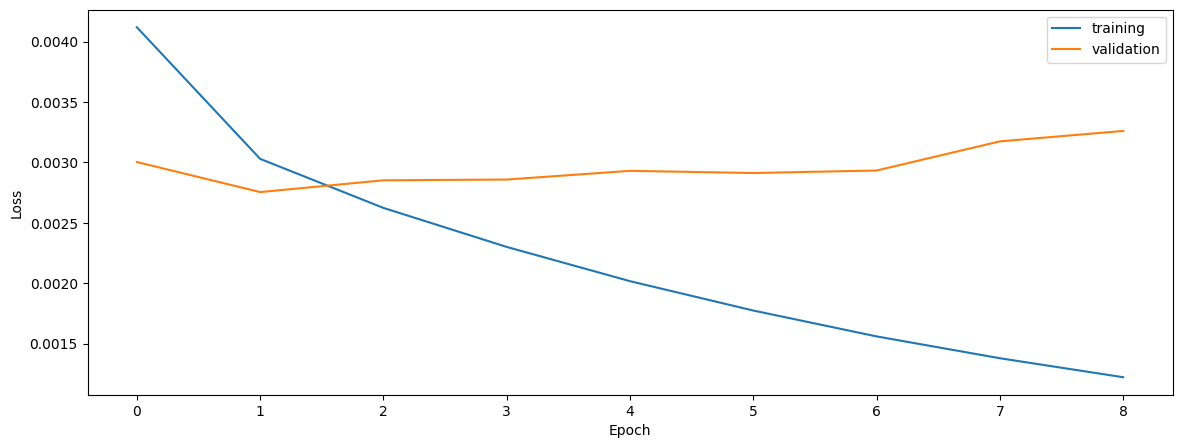

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8426194303107687
0.8277862659005787
0.8183805790423172


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8426194303107687
0.8277862659005787
0.8183805790423172


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8421007985338458
0.8237027580497699
0.8207314292163201


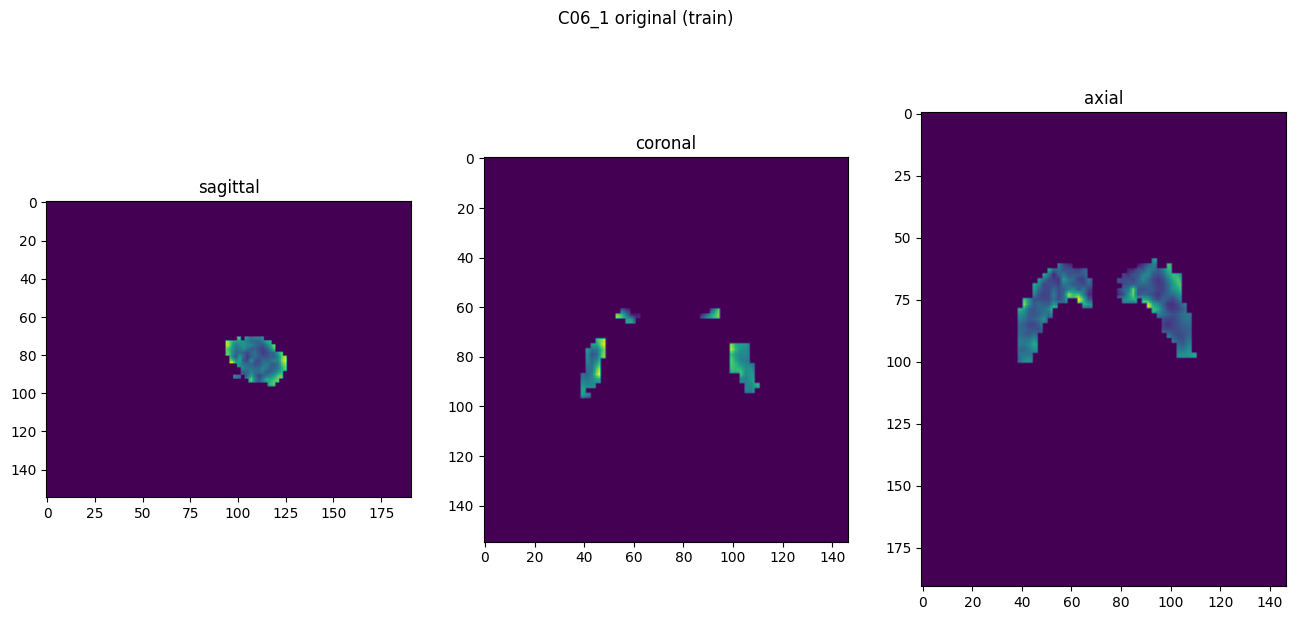

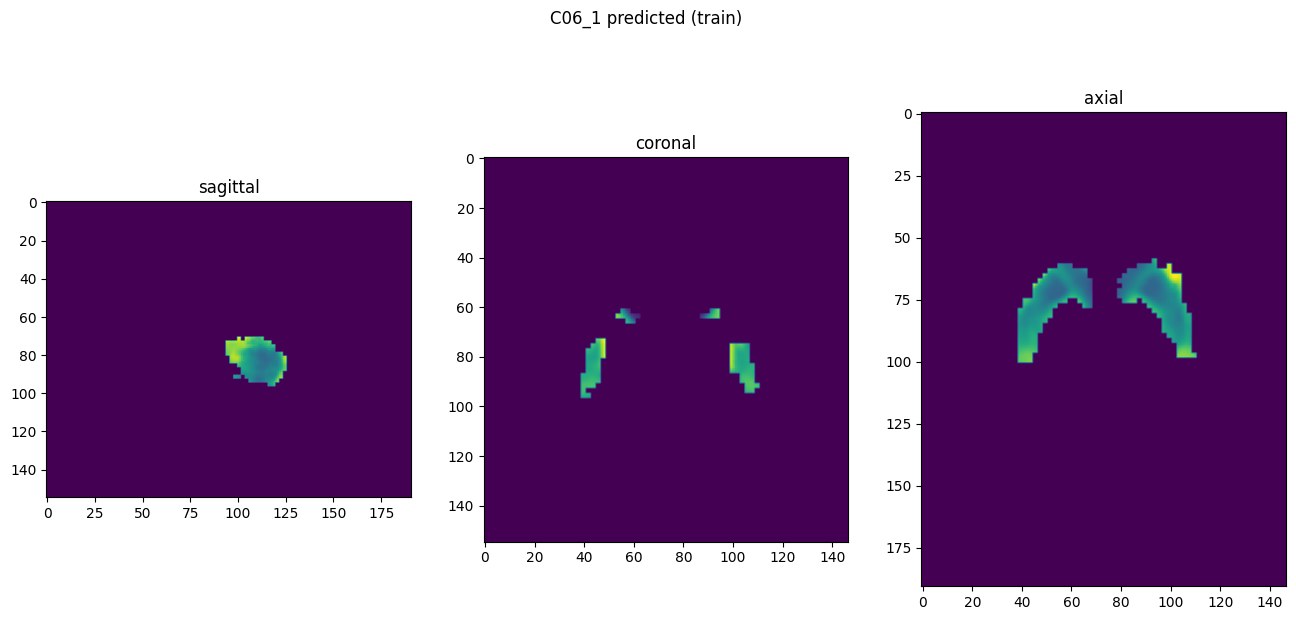

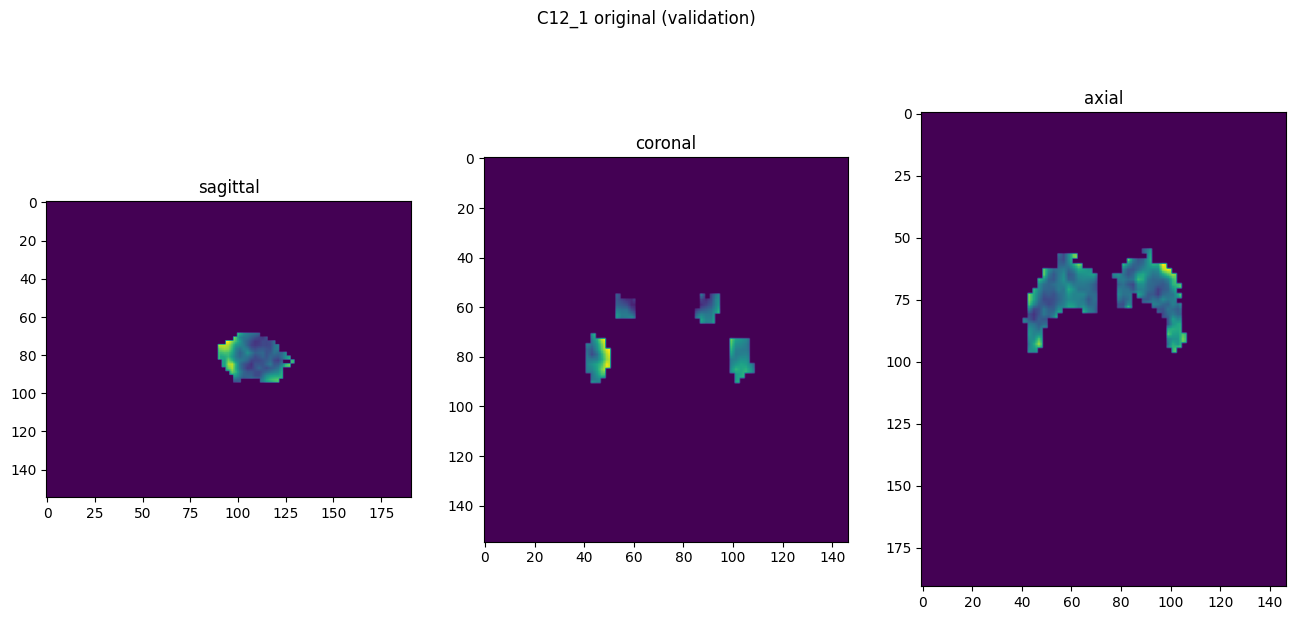

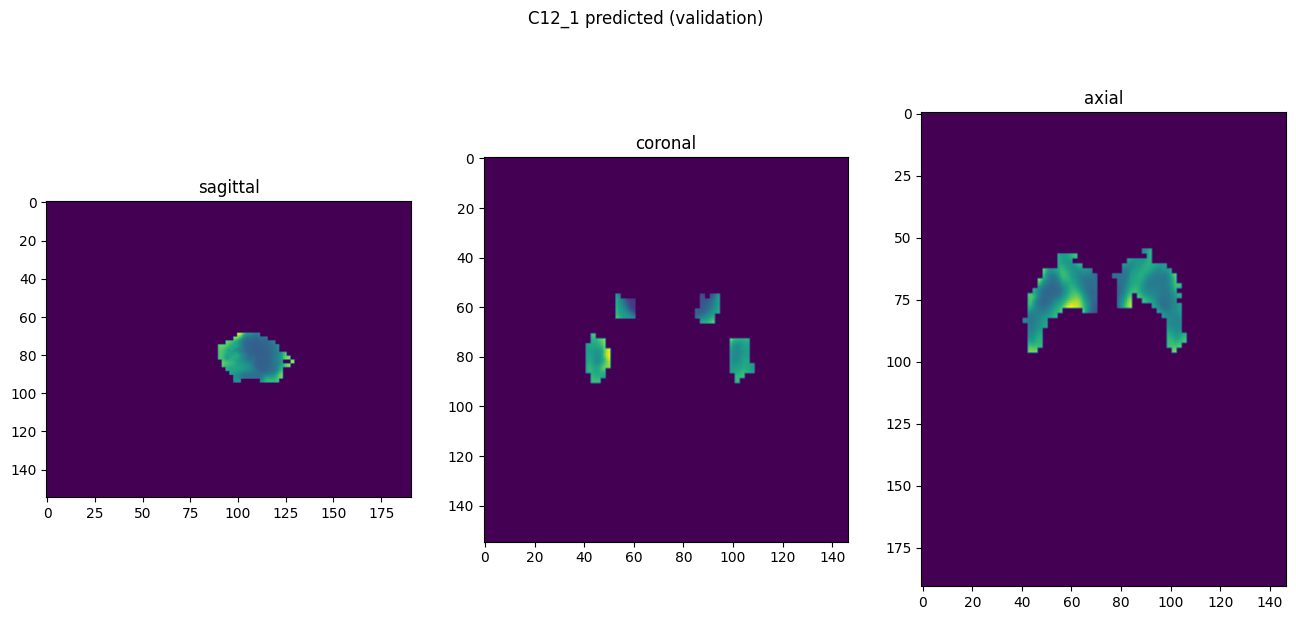

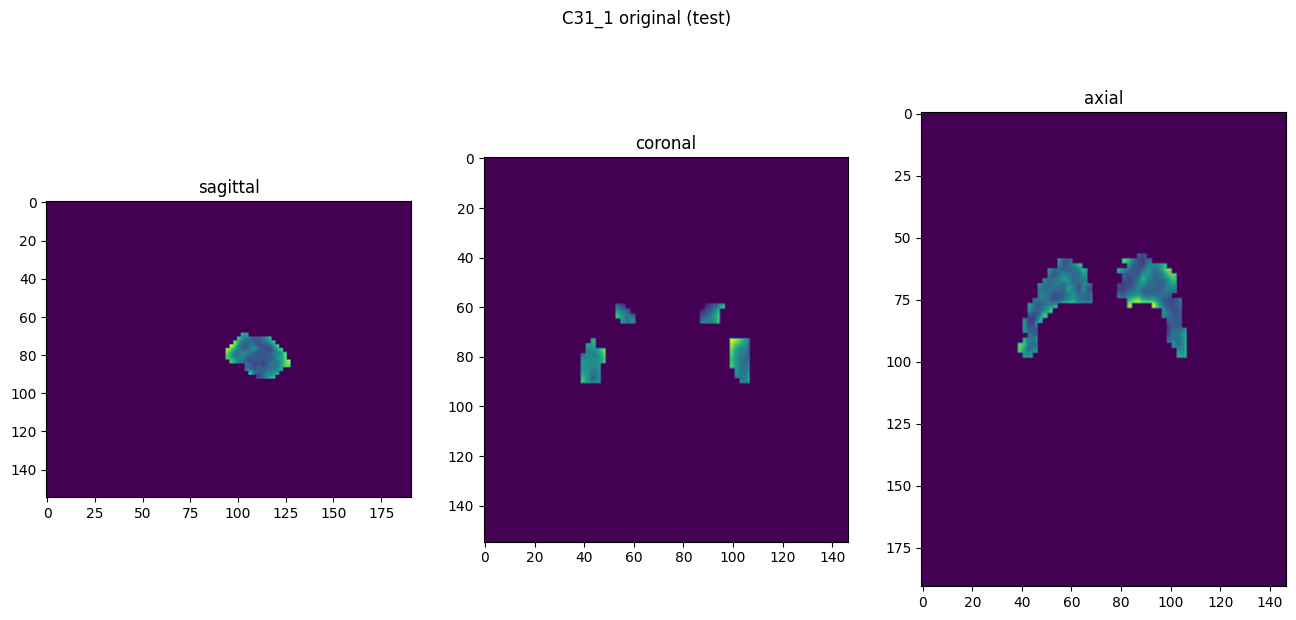

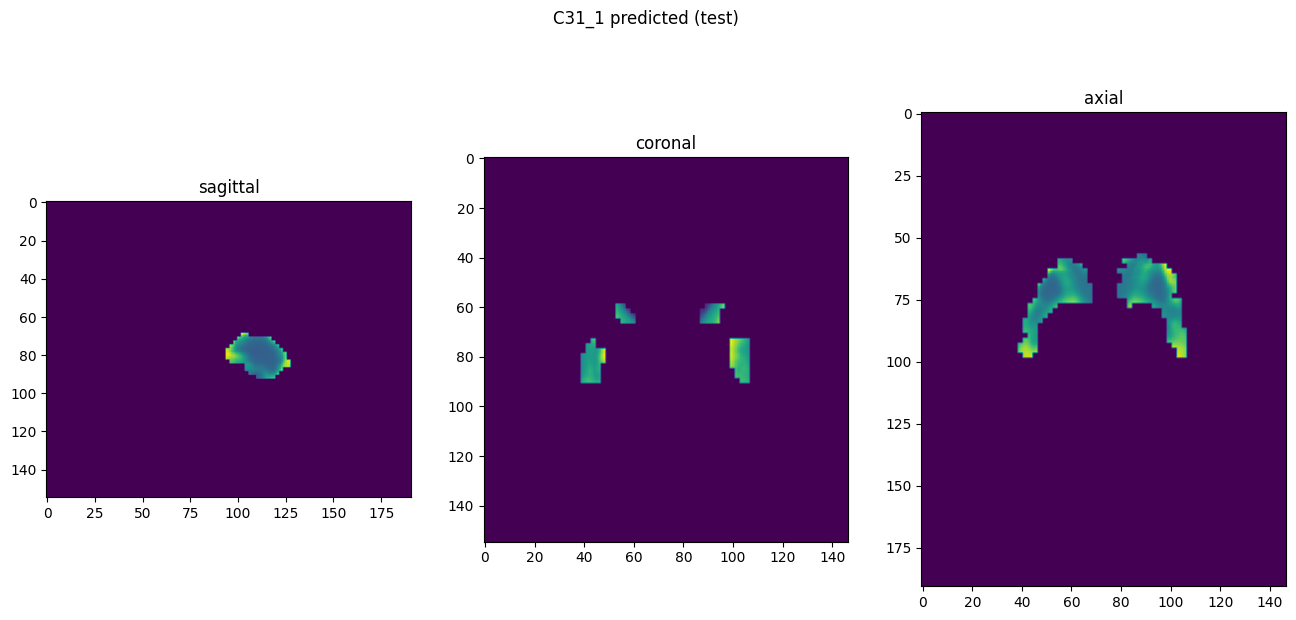

In [10]:
showResults(model, gen, threshold=None, background=False)